# PCA feature maps

In this notebook, we'll compute [PCA feature maps](https://github.com/facebookresearch/dinov3/blob/main/notebooks/pca.ipynb) for our pretrained flat map MAE (fm-MAE) model.

Outline:
- extract a sample of 16s fMRI clips. We will use trial-locked task fMRI clips for each HCP task and condition.
- compute feature embeddings
- fit PCA
- plot RGB color-mapped PCA feature maps

In [1]:
import json

import torch
import numpy as np
import datasets as hfds
from matplotlib import pyplot as plt
from huggingface_hub import get_token, hf_hub_download
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.flat_data import make_flat_wds_dataset, make_flat_transform
import flat_mae.models_mae as models_mae
from flat_mae.visualization import FC_CMAP
from flat_mae.utils import random_seed

In [2]:
plt.rcParams["figure.dpi"] = 100

random_seed(7338)

Load a pretrained checkpoint for a ViT-B/16 encoder with temporal patch size 16.

In [3]:
model_name = "fm_mae_vit_base_patch16-16.hcp"
model = models_mae.MaskedAutoencoderViT.from_pretrained(f"medarc/{model_name}")
print(model)

num_params = sum(p.numel() for p in model.parameters())
num_params_encoder = sum(p.numel() for p in model.encoder.parameters())

print(f"num params (total): {num_params / 1e6:.1f}M")
print(f"num params (encoder): {num_params_encoder / 1e6:.1f}M")

MaskedAutoencoderViT(
  decoding=attn, t_pred_stride=2, pred_edge_pad=0, no_decode_pos=False
  (encoder): MaskedEncoder(
    class_token=True, reg_tokens=0, no_embed_class=False, mask_drop_scale=False
    (patchify): Patchify3D((16, 224, 560), (16, 16, 16), in_chans=1)
    (patch_embed): Linear(in_features=4096, out_features=768, bias=True)
    (pos_embed): SeparablePosEmbed(768, (1, 14, 35))
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          num_heads=12
          (q): Linear(in_features=768, out_features=768, bias=True)
          (k): Linear(in_features=768, out_features=768, bias=True)
          (v): Linear(in_features=768, out_features=768, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linea

Create a streaming dataset which returns trial-locked fMRI clips for all the HCP task fMRI runs.

⚠️ You'll need to accept the HCP data use agreement to get gated access to the dataset. You may also need to authenticate with `hf auth login` or run

```python
from huggingface_hub import login
login()
```

In [4]:
# webdataset streaming url
hf_token = get_token()
url = "https://huggingface.co/datasets/medarc/hcp-flat-wds/resolve/main/hcp-flat_{0000..0099}.tar"
url = f"pipe:curl -s -L {url} -H 'Authorization:Bearer {hf_token}'"

# map of hcp trial types to integer target ids
trial_type_target_id_map_path = hf_hub_download(
    "medarc/fmri-fm", "datasets/hcp_trial_type_target_id_map.json", repo_type="dataset"
)
with open(trial_type_target_id_map_path) as f:
    trial_type_target_id_map = json.load(f)

# event clipping gets trial-locked clips
dataset = make_flat_wds_dataset(
    url,
    clipping="event",
    shuffle=True,
    target_id_map=trial_type_target_id_map,
    target_key="trial_type",
)

transform = make_flat_transform(normalize="frame")
dataset = dataset.map(transform)

Extract a balanced number of clips for each HCP trial type. This takes a few minutes. Using huggingface dataset to cache the result.

In [5]:
def generate_samples(dataset, target_id_map, samples_per_target: int = 5):
    loader = DataLoader(dataset, batch_size=None, num_workers=4)
    counts = {target: 0 for target in target_id_map.values()}
    for sample in loader:
        target = sample["target"]
        if counts[target] < samples_per_target:
            counts[target] += 1
            yield sample
        if min(counts.values()) >= samples_per_target:
            break

In [6]:
samples_per_target = 10

samples = hfds.Dataset.from_generator(
    generate_samples,
    gen_kwargs={
        "dataset": dataset,
        "target_id_map": trial_type_target_id_map,
        "samples_per_target": samples_per_target,
    },
)

print(samples)

Dataset({
    features: ['image', 'img_mask', 'target', '__key__'],
    num_rows: 210
})


Run inference for the extracted samples. Save the embeddings as well as images, targets, and sample keys (which have some useful metadata).

In [7]:
samples.set_format("torch")

images = []
targets = []
embeddings = []
keys = []
with torch.inference_mode():
    for sample in tqdm(samples):
        target = sample["target"]
        img = sample["image"][None]
        mask = sample["img_mask"].expand_as(img)
        _, _, embeds = model.forward_embedding(img, mask)
        images.append(img.squeeze(0))
        targets.append(target)
        embeddings.append(embeds.squeeze(0))
        keys.append(sample["__key__"])

images = torch.stack(images).numpy()
targets = torch.stack(targets).numpy()
embeddings = torch.stack(embeddings).numpy()

100%|██████████| 210/210 [00:18<00:00, 11.53it/s]


Fit PCA.

We normalize the embeddings independently for each patch. This removes position-related information from the embeddings and makes the maps *much* clearer.

We also have an option to remove the difference between phase encoding directions (we'll see why later).

In [8]:
N, P, D = embeddings.shape
embeddings_norm = (embeddings - embeddings.mean(axis=0, keepdims=True)) / embeddings.std(
    axis=0, keepdims=True
)

remove_pe_dir = False

if remove_pe_dir:
    print("Removing difference between LR and RL phase encoding direction")
    dir_is_lr = np.array(["dir-LR" in key for key in keys])
    print(f"LR fraction={np.mean(dir_is_lr):.2f}")
    embeddings_norm[dir_is_lr] -= embeddings_norm[dir_is_lr].mean(axis=(0, 1))
    embeddings_norm[~dir_is_lr] -= embeddings_norm[~dir_is_lr].mean(axis=(0, 1))

In [9]:
n_components = 5
components = PCA(n_components, whiten=True).fit_transform(embeddings_norm.reshape(-1, D))
components = components.reshape(N, P, n_components)

Embeddings are computed only for valid non-empty patches. So we have to "unmask" the embeddings to reconstruct the full embedding grid.

> **Note:** This assumes all samples have the same image mask.

In [10]:
# get the mask of valid patches
sample = samples[0]
img = sample["image"][None]
mask = sample["img_mask"].expand_as(img)
H, W = img.shape[-2:]

patch_mask = model.encoder.patchify(mask)
patch_mask = patch_mask.squeeze().any(dim=-1).numpy()

M = patch_mask.shape[0]
n_valid_patches = patch_mask.sum().item()
grid_size = model.encoder.patchify.grid_size
print(f"total patches={M}, valid={n_valid_patches}, grid size={grid_size}")

patch_mask_grid = patch_mask.reshape(grid_size)

total patches=490, valid=364, grid size=(1, 14, 35)


In [11]:
# fill the values from the valid components and reshape into a grid
component_maps = np.zeros((N, M, n_components))
component_maps[:, patch_mask] = components
component_maps = component_maps.reshape((N, *grid_size, n_components))
print("component_maps:", component_maps.shape)

component_maps: (210, 1, 14, 35, 5)


Plot the maps!

- each row contains random examples for a different HCP task condition
- within each row, there are 3 random examples.
- for each example there is a pair of images: input image and pca feature map
- the subject ID and phase encoding direction (LR or RL) for each image is labeled in the upper left of the input image.

In [12]:
def plot_rgb_component_maps(
    conds: list[str] | None = None,
    num_examples: int = 3,
    comp_offset: int = 0,
    frame_idx: int = 5,
):
    if conds is None:
        conds = list(trial_type_target_id_map)

    ploth = 1.0
    plotw = (W / H) * ploth

    nr, nc = len(conds), 2 * num_examples

    f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
    axs = axs.flatten()

    sort_ids = np.argsort(targets)

    for ii, ax in enumerate(axs):
        plt.sca(ax)
        row_id = ii // nc
        col_id = (ii % nc) // 2
        cond = conds[row_id]
        target = trial_type_target_id_map[cond]
        idx = target * samples_per_target + col_id
        idx = sort_ids[idx]
        assert target == targets[idx]

        key = keys[idx]
        meta = dict(item.split("-") for item in key.split("_"))

        if ii % 2 == 0:
            img = images[idx, 0, frame_idx]
            img = np.where(img != 0, img, np.nan)
            plt.imshow(img, cmap=FC_CMAP, interpolation="none")
            plt.text(
                0.01,
                0.99,
                "{sub} {dir}".format(**meta),
                fontsize=7,
                transform=ax.transAxes,
                va="top",
                bbox=dict(facecolor="w", edgecolor="none", alpha=0.5, pad=0.0),
            )
        else:
            img = component_maps[idx, 0, :, :, comp_offset : comp_offset + 3]
            img = torch.sigmoid(2.0 * torch.from_numpy(img)).numpy()
            plt.imshow(img, interpolation="none")

            # for debugging
            # print(target, cond, key)

        plt.xticks([])
        plt.yticks([])
        ax.spines[:].set_visible(False)

        if ii % nc == 0:
            task = meta["task"]
            plt.ylabel(f"{task} {cond}", fontsize=7)

    plt.tight_layout(pad=0.25)
    return f

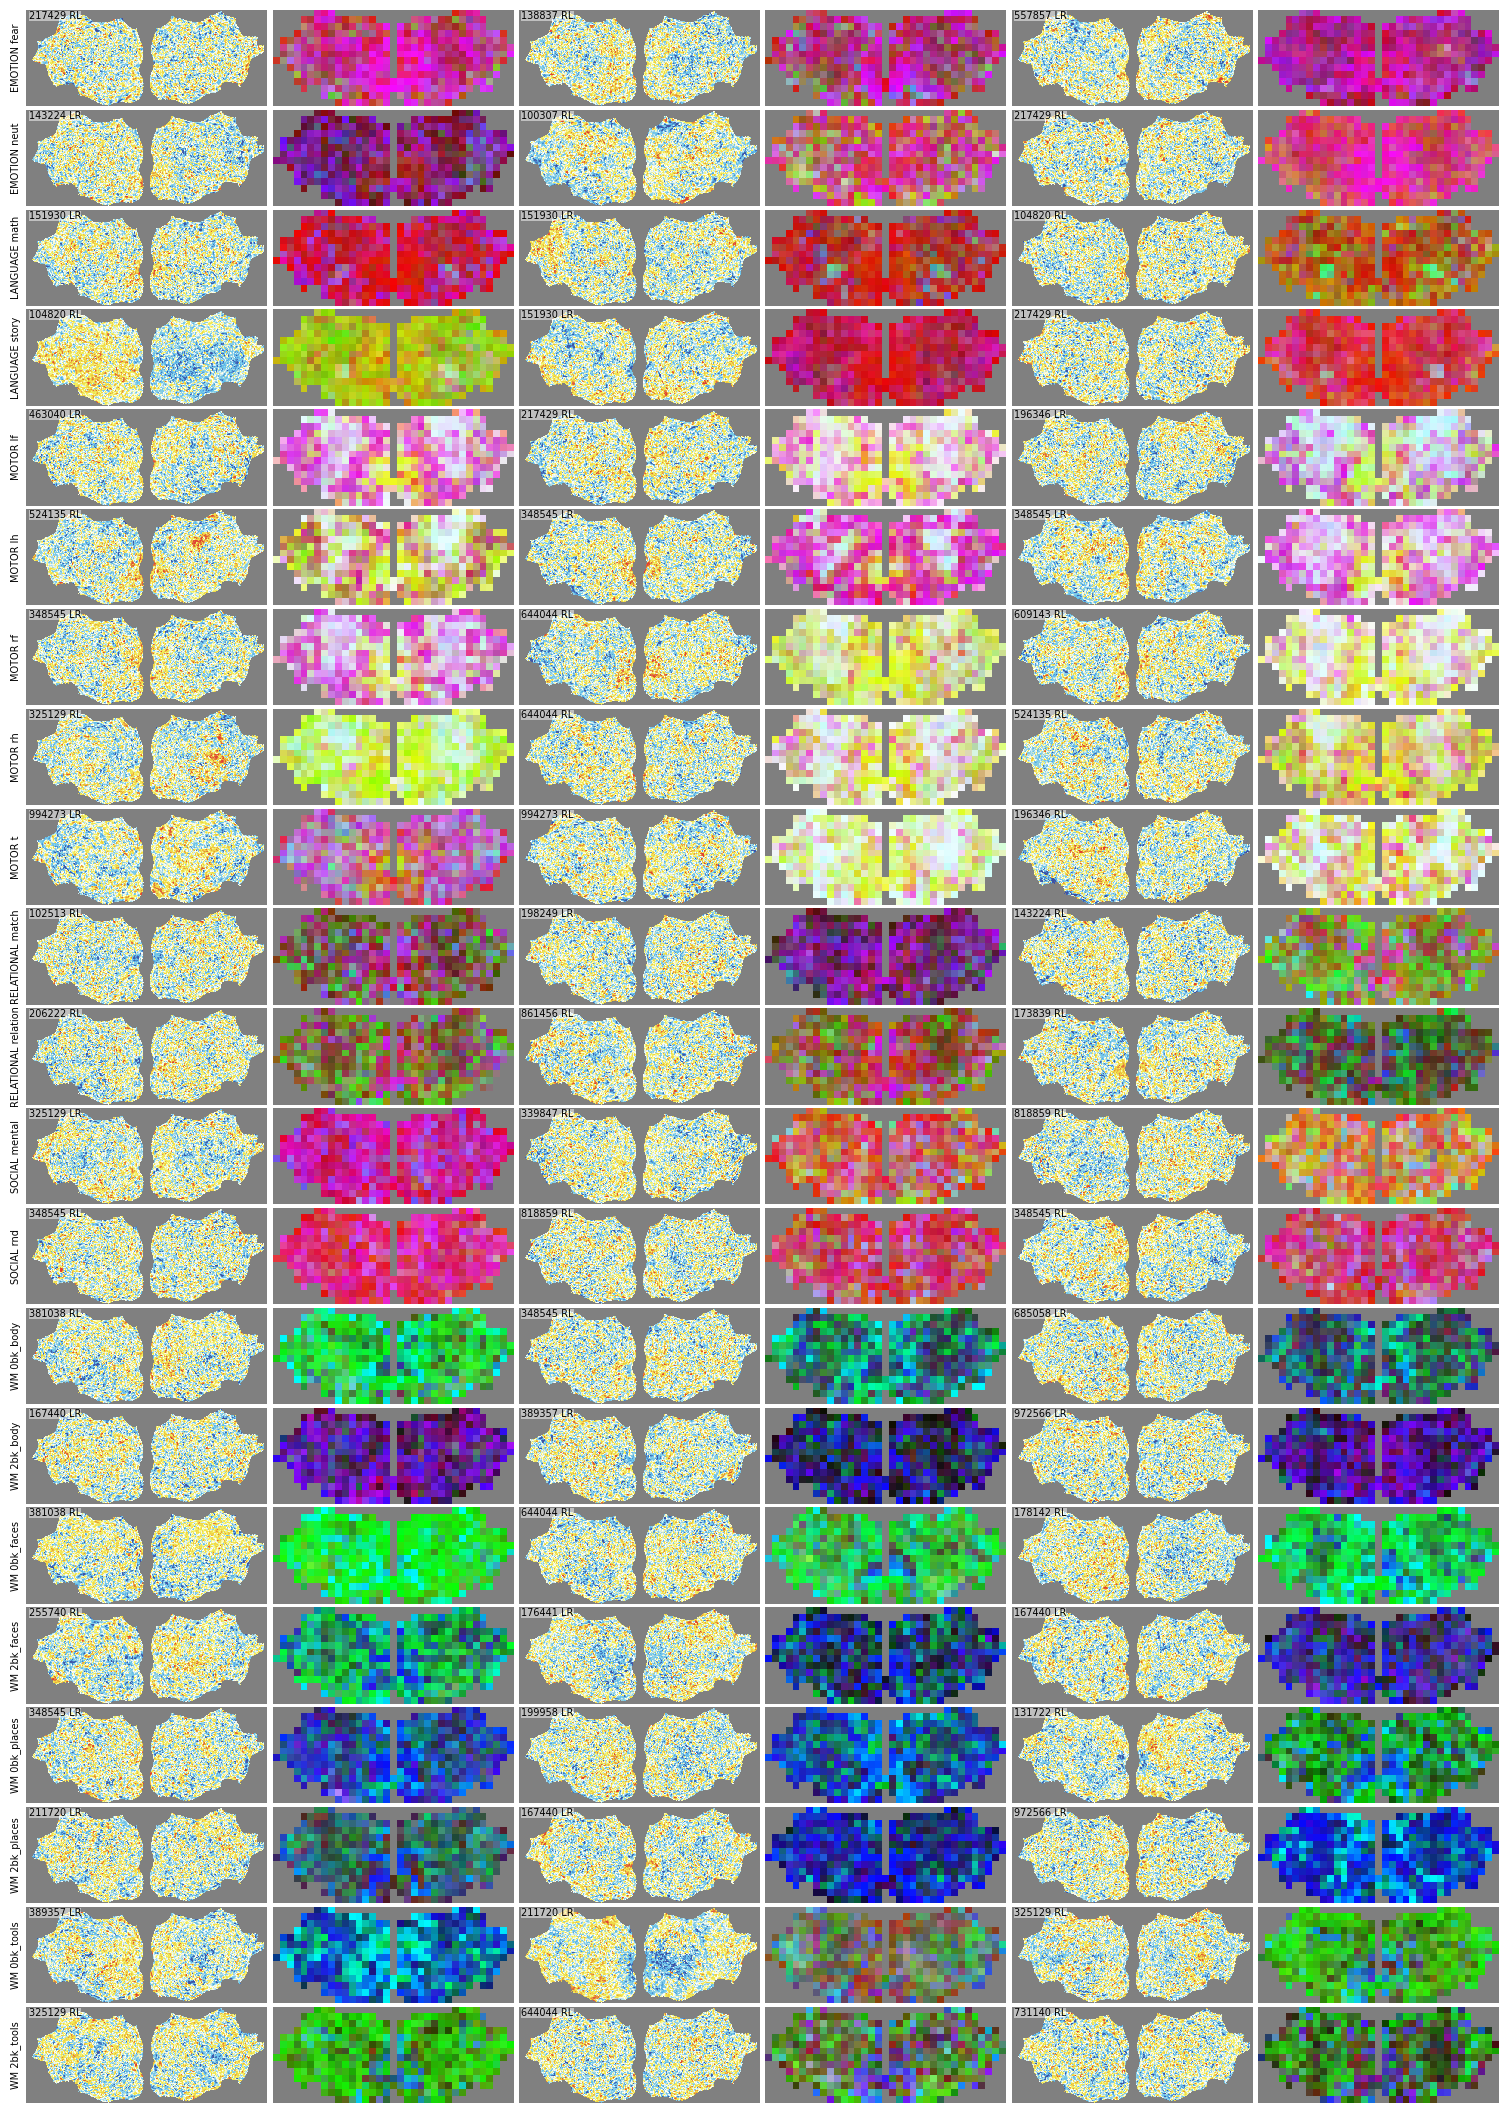

In [13]:
f = plot_rgb_component_maps()
f.savefig(f"pca_feat_maps_{model_name}_nodir-{int(remove_pe_dir)}.png", dpi=150)

Notes:

- Each task has a pretty distinctive PCA color signature! 

- On the other hand, the specific conditions within each task are not very distinguishable.

- Interestingly, the phase encoding direction is also visually apparent in the feature maps. (See for example the `WM 2bk_body` row and the one below it.)

What if we remove the difference between LR and RL phase encoding direction? Go back and try it out by setting `remove_pe_dir = True`.